In [27]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

%matplotlib notebook

## Load data

In [28]:
def make_int(text):
    label = text.strip('" ')
    return int(-1 if label == '<=50K' else 1)

column_names = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
train_X = pd.read_csv('data/hw2/train.csv', usecols=[0, 2, 4, 10, 11, 12], names=column_names)
train_Y = pd.read_csv('data/hw2/train.csv', usecols=[14], names=['label'],converters={'label': make_int})
test_X = pd.read_csv('data/hw2/test.csv', usecols=[0, 2, 4, 10, 11, 12], names=column_names)

In [29]:
print(f'train data shape: {train_X.shape}')
print(f'test data shape: {test_X.shape}')
train_X.head()

train data shape: (43957, 6)
test data shape: (4885, 6)


age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week
0   34  287315              9             0             0              40
1   43  145175             13             0             0              42
2   45   33798             14             0             0              40
3   23  180497             13             0             0              32
4   65  145628              6             0             0              40

In [30]:
train_Y.head()

label
0     -1
1      1
2     -1
3     -1
4     -1

## Process data

#### Scale data

In [31]:
scaled_train_X = pd.DataFrame(preprocessing.scale(train_X), columns=column_names)
scaled_test_X = pd.DataFrame(preprocessing.scale(test_X), columns=column_names)

/Users/qingemeng/Documents/dev/cs498aml/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.
/Users/qingemeng/Documents/dev/cs498aml/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [32]:
scaled_test_X.head()

age    fnlwgt  education-num  capital-gain  capital-loss  \
0 -0.198185 -0.608772      -0.028374     -0.152805     -0.223378   
1 -0.926873 -1.177546       1.503180     -0.152805     -0.223378   
2  1.404928  0.356638      -0.411262     -0.152805      4.230006   
3  1.550665 -1.074318      -0.028374     -0.152805     -0.223378   
4 -1.364085  0.286507      -0.028374     -0.152805     -0.223378   

   hours-per-week  
0       -0.038573  
1       -2.353443  
2       -0.038573  
3        0.733050  
4       -0.810197

#### Split data

In [33]:
def split_data(df, ratio):
    set1 = df.sample(frac=ratio)
    set2 = df.sample(frac=(1 - ratio))
    return set1, set2

In [34]:
regularization_train, regularization_validation = split_data(scaled_train_X.join(train_Y), 0.9)

In [35]:
assert regularization_train.shape[0] + regularization_validation.shape[0] == train_X.shape[0]
regularization_train.head()

age    fnlwgt  education-num  capital-gain  capital-loss  \
11604 -1.213454  0.091315      -0.030600     -0.144172      -0.21644   
2859  -0.556946  1.065302      -0.030600     -0.144172      -0.21644   
24480 -0.119274 -0.248768      -0.420255     -0.144172      -0.21644   
804    1.777303 -0.669640      -0.420255     13.104039      -0.21644   
43540  0.974905  0.116279      -0.420255     -0.144172      -0.21644   

       hours-per-week  label  
11604       -1.899465     -1  
2859        -0.033567     -1  
24480       -0.033567     -1  
804         -0.033567      1  
43540       -0.033567     -1

In [36]:
reg_validate_X = regularization_validation.drop(['label'], axis=1)
reg_validate_Y = regularization_validation['label']

## Stochastic Gradient Descent

In [37]:
def predict(feature_vec, a, b):
    return np.sign(np.dot(feature_vec, a.T) + b)
    
def calculate_accuracy(actual, predicts):
    TP = 0
    num_total = len(actual)
    for i in range(num_total):
        if actual[i] == predicts[i]:
            TP = TP + 1
    return TP/num_total

def evaluate(test_set, a, b):
    test_X = test_set.drop(['label'], axis=1)
    test_Y = test_set['label']
    predicts = test_X.apply(predict, args=(a, b, ), axis=1)
    return calculate_accuracy(np.array(test_Y), np.array(predicts))

In [38]:
def gradient_of_cost(feature_vec, label, a, b, lam=0):
    if label * (np.dot(feature_vec, a.T) + b) < 1:
        gradient_a = lam * a - (feature_vec * label)
        gradient_b = 0 - label
    else:
        gradient_a = lam * a
        gradient_b = 0
  
    return [gradient_a, gradient_b]

In [39]:
def step(feature_vec, label,a, b, lam, learning_rate):
#   c = cost_function(x_batch,y_batch,a=a_est,b=b_est)
    g = gradient_of_cost(feature_vec, label,a=a,b=b,lam=lam)
    a_new = a - learning_rate * g[0]
    b_new = b - learning_rate * g[1]
    return a_new, b_new

In [40]:
def stochastic_gradient_descent(X, Y, initial_a, initial_b, steps, held_out_set, learning_rate, lam):
    a = initial_a
    b = initial_b
    plots = np.array([])
    for i in range(steps):
        n = np.random.randint(0, len(X)) # Batch size of 1.
        a, b = step(X.iloc[n], Y.iloc[n], a, b, lam, learning_rate)
        if((i+1)%30 == 0):
            accuracy = evaluate(held_out_set, a, b)
            magnitude = np.linalg.norm(a)
            plots = np.concatenate((plots, {'acc': accuracy, 'mag': magnitude}), axis=None)
    return a, b, plots

In [41]:
def seperate_held_out(X, size):
    random_indices = np.random.randint(0, len(X), size=size)
    return X.drop(X.index[random_indices]), X.iloc[random_indices]

In [42]:
def svg_fit(train_data, learning_rate, lam, epoch=50, initial_a=np.random.rand(1,6).flatten() - 1, initial_b=0, set_held_out_size=50, steps=300):
    X, held_out_set = seperate_held_out(train_data, set_held_out_size)
    if(X.shape[0] + held_out_set.shape[0] != train_data.shape[0]):
        print(f'total: {train_data.shape}, X.shape: {X.shape}, held out shape: {held_out_set.shape}')

    train_X = X.drop(['label'], axis=1)
    train_Y = X['label']
    a, b = initial_a, initial_b
    plots_each_lambda = np.array([])
    for i in tqdm(range(epoch)):
        a, b, plots_each_epoch = stochastic_gradient_descent(train_X, train_Y, a, b, steps, held_out_set, learning_rate=learning_rate, lam=lam)
        plots_each_lambda = np.concatenate((plots_each_lambda, plots_each_epoch), axis=None)
    return a, b, plots_each_lambda

In [52]:
lambdas = [1e-7,1e-6, 1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1]
epoch = 50
plots = []
for lam in lambdas:
    learning_rate = 1/(0.01* epoch + 50)
    a, b, plots_each_lambda = svg_fit(regularization_train, epoch=epoch, learning_rate=learning_rate, lam=lam)
    plots.append(plots_each_lambda)
    print(np.array(a), b)
    accuracy = evaluate(regularization_validation, a, b)
    print(f'lamda: {lam}, Accuracy: {accuracy}')
# print(accuracies.shape)


[0.08246269 0.03119354 0.18854528 1.88918855 0.374911   0.21911505] -0.8600000000000005
lamda: 1e-07, Accuracy: 0.8080072793448589



[0.23967446 0.02372211 0.31105637 1.9386151  0.33179636 0.30516635] -0.7900000000000005
lamda: 1e-06, Accuracy: 0.8050500454959054



[0.13246984 0.01627833 0.12435626 1.79493658 0.36684283 0.18642744] -0.8100000000000005
lamda: 1e-05, Accuracy: 0.8089171974522293



[0.14277837 0.00458366 0.16754762 1.74159225 0.25281417 0.20101961] -0.7900000000000005
lamda: 0.0001, Accuracy: 0.815059144676979



[ 0.18648773 -0.01797296  0.16465764  1.69991766  0.11661151  0.20131297] -0.8800000000000006
lamda: 0.001, Accuracy: 0.8075523202911737



[0.03516246 0.08110726 0.09277256 1.27252416 0.21310964 0.08733255] -0.9200000000000006
lamda: 0.01, Accuracy: 0.8148316651501365



[0.1190389  0.01613417 0.03935504 0.55074464 0.05242875 0.11397792] -1.0100000000000007
lamda: 0.1, Accuracy: 0.783894449499545



[0.00026093 0.01066601 0.01375486 0.06322499 0.04370443 0.02860241] -1.0300000000000007
lamda: 1, Accuracy: 0.7668334849863512


## Plots

<IPython.core.display.Javascript object>


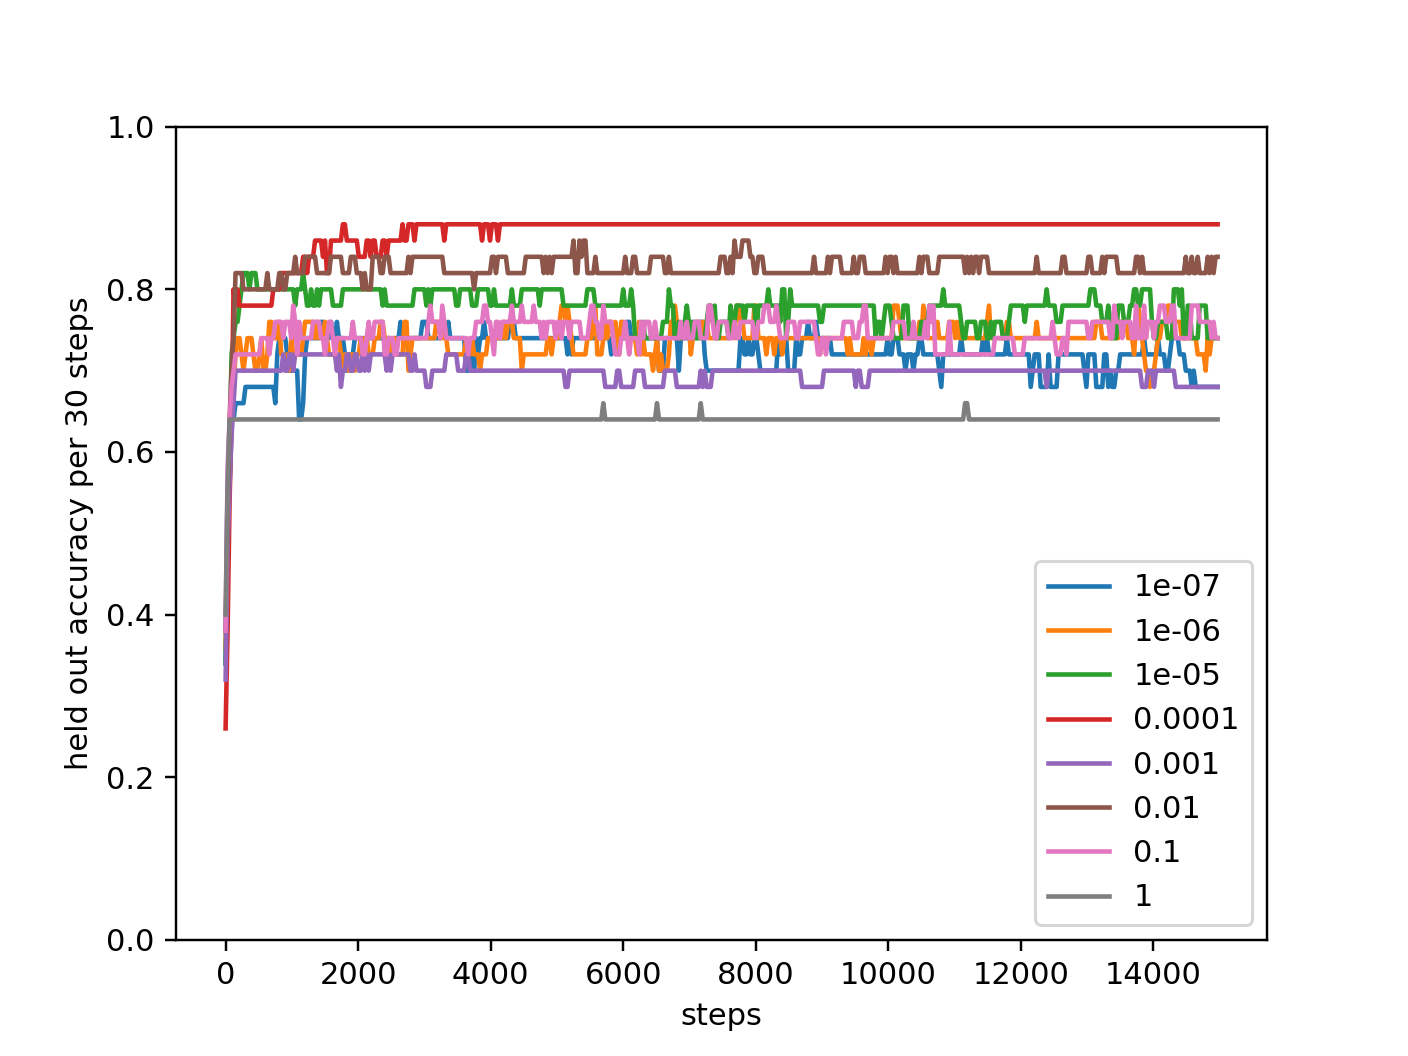

In [53]:
fig, ax = plt.subplots()
for plot_x in plots:
    accs = []
    for pairs in plot_x:
        accs.append(pairs['acc'])
   
    ax.plot(np.array(range(epoch*300//30)) * 30, accs)
    
plt.gca().set_ylim(0, 1)
ax.set_xlabel('steps')
ax.set_ylabel('held out accuracy per 30 steps')
plt.legend(lambdas)
plt.show()
# plt.savefig('reports/hw2/a.png', dpi=500)

<IPython.core.display.Javascript object>


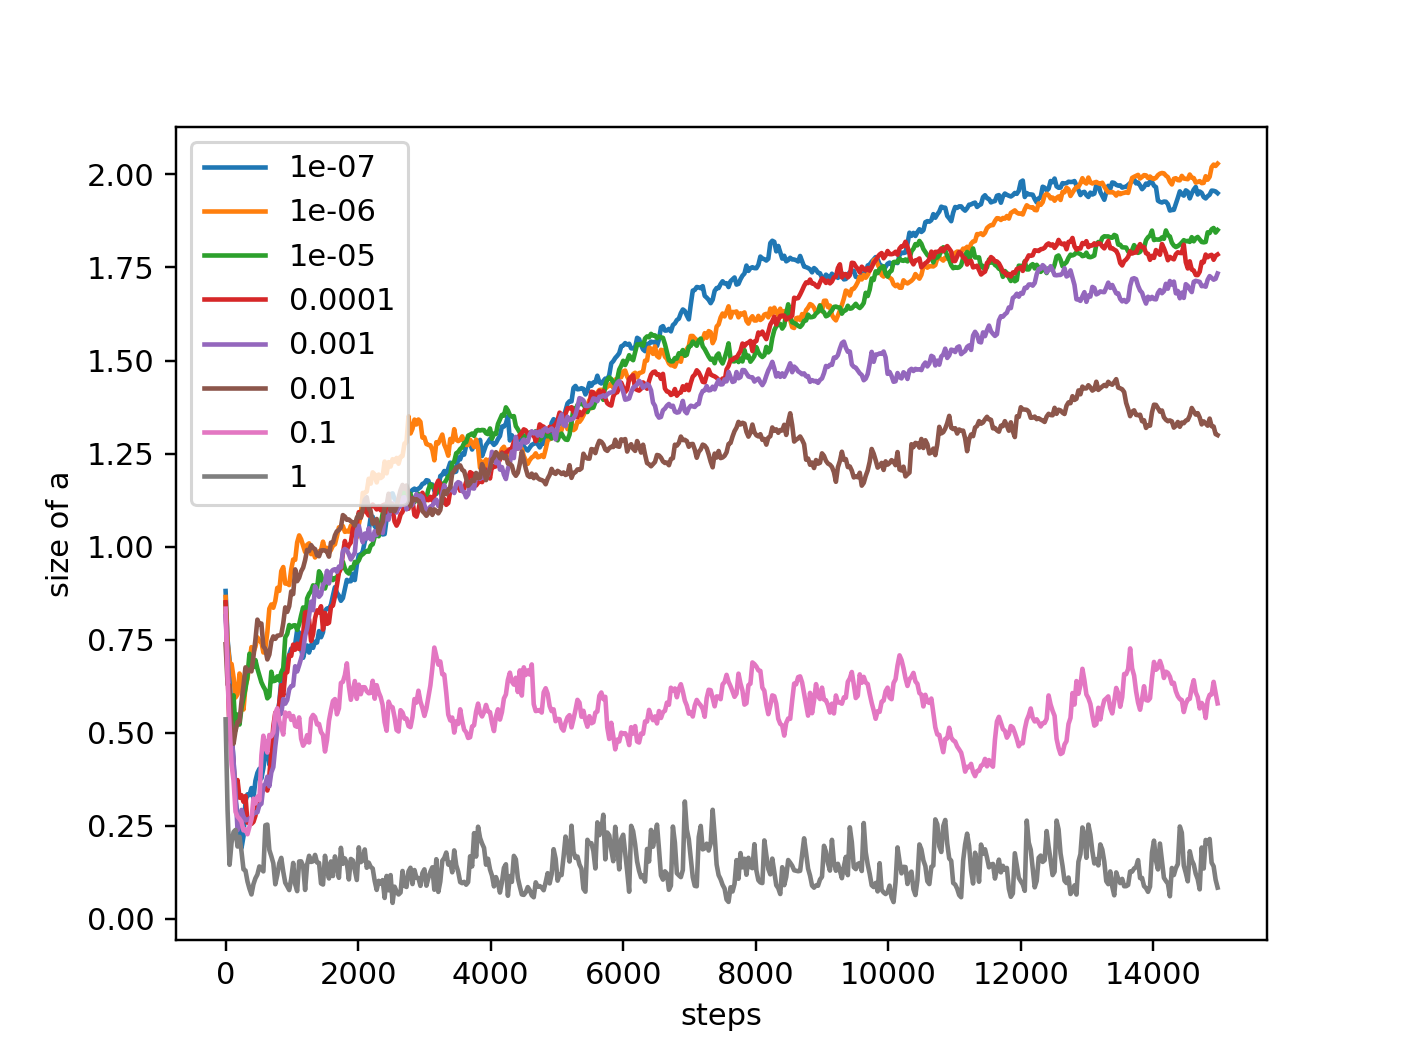

In [54]:
fig, ax = plt.subplots()

for plot_x in plots:
    mags = []
    for pairs in plot_x:
        mags.append(pairs['mag'])
    
    plt.plot(np.array(range(epoch*300//30)) * 30, mags)
ax.set_xlabel('steps')
ax.set_ylabel('size of a')
plt.legend(lambdas)
plt.show()
# plt.savefig('reports/hw2/b.png', dpi=500)


## Predict test sets

In [55]:
# best_a, best_b = np.array([ 0.13380255, -0.05997235, 0.08621807, 1.12921564, 0.24495903, 0.03443137]), -0.8712871287128716
# best_a, best_b = np.array([-0.0089788   ,0.07213142  ,0.19591787 , 1.74356534,  0.29986223,  0.08221555]), -0.831683168316832
# best_a, best_b = np.array([0.10361225, 0.05591169, 0.14917444, 1.9220355,  0.02682067, 0.03830469]), -0.9504950495049509
# best_a, best_b = np.array([0.02972564, -0.02625366,  0.05633731 , 0.33127433 , 0.06784379 , 0.11333589]), -0.9803921568627457
# *best_a, best_b = np.array([0.15910443, -0.05062148,  0.31016051,  1.91697131 , 0.24610324 , 0.11390792]), -0.8910891089108914
best_a, best_b = np.array([ 0.14277837, 0.00458366 ,0.16754762, 1.74159225 ,0.25281417, 0.20101961] ), -0.7900000000000005

In [56]:
test_predicts = scaled_test_X.apply(predict, args=(best_a, best_b, ), axis=1).replace(-1, '<=50K').replace(1, '>50K')
print(test_predicts.shape)
np.savetxt(r'reports/hw2/submission.txt', test_predicts.values, fmt='%s')

(4885,)
